In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "20"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc
from hits.visualize import interactive
from bokeh.io import output_notebook
from hdbscan import HDBSCAN

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Loading BokehJS ...

# Parameters

In [2]:
PREFIX = '20240309_RPE1_CRISPRa_'

# Data loading and filtering droplets

In [3]:
full_pop = sc.read_h5ad('/data/norman/southark/tfs_standardized/240308_RPE1_CRISPRa_final_population.h5ad')

In [4]:
full_pop = CellPopulation(pd.DataFrame(full_pop.X.todense().A, index=full_pop.obs.index, columns=full_pop.var.index), full_pop.obs, full_pop.var, calculate_statistics=False)

Done.


In [ ]:
# remove low expression genes that we don't fit regressions to

In [5]:
strip_low_expression(full_pop, threshold=0.2)

In [6]:
full_pop = full_pop.subpopulation(cells='pairwise_singlet_equivalent_UMI_count > 0', calculate_statistics=False)

Done.


In [7]:
full_pop.cells['num_cells'].value_counts()

1.0    321769
2.0    253113
3.0    170070
4.0    105272
Name: num_cells, dtype: int64

# Clean up perturbation names

In [9]:
feature_library = pd.read_csv('/lila/data/norman/southark/rpe1_tfs/rpe1_tfs_crispra_w_controls.csv')
feature_library['end'] = feature_library['sequence'].map(lambda x: x[-5:])
feature_library['name'] = feature_library['name'].replace({'non_targeting': 'non-targeting'})
feature_library['new_name'] = feature_library['name'] + '_' + feature_library['sequence']

In [10]:
name_mapper = pd.Series(feature_library['new_name'].values, index=feature_library['id'])

In [11]:
name_mapper

id
AATF_GGAAGCGCGCAGAAGGTTGA                      AATF_GGAAGCGCGCAGAAGGTTGA
AATF_GCGTGCGAGTGCGCGGGAAG                      AATF_GCGTGCGAGTGCGCGGGAAG
AATF_GCGCAGAAGGTTGAAGGGAT                      AATF_GCGCAGAAGGTTGAAGGGAT
AATF_GGGCGTTGCTAGCATGAAGG                      AATF_GGGCGTTGCTAGCATGAAGG
AATF_GTGAAGGGATTGGAGCCGTA                      AATF_GTGAAGGGATTGGAGCCGTA
                                                     ...                
non_targeting_GAACGGGCCGTGATCGGACC    non-targeting_GAACGGGCCGTGATCGGACC
non_targeting_GGCCCTCCCCACCGGCACGA    non-targeting_GGCCCTCCCCACCGGCACGA
non_targeting_GTCGTTATCTCGCTATTTCG    non-targeting_GTCGTTATCTCGCTATTTCG
non_targeting_GTGGTTATACCCGACTAGAC    non-targeting_GTGGTTATACCCGACTAGAC
non_targeting_GTCCACAAGACGTGCTCGCA    non-targeting_GTCCACAAGACGTGCTCGCA
Length: 10979, dtype: object

In [12]:
control_guides = full_pop.cells.query('control')['guide_identity'].unique()
off_target_controls = np.setdiff1d(full_pop.cells.query('guide_target=="non"')['guide_identity'].unique(), control_guides)

In [13]:
off_target_mapper = pd.Series(map(lambda x: x.replace('non_targeting', 'off-target'), off_target_controls), index=off_target_controls)

In [14]:
feature_library['corrected_name'] = feature_library['id'].map(lambda x: off_target_mapper.get(x, x))
feature_library['corrected_name'] = feature_library['corrected_name'].map(lambda x: name_mapper.get(x, x))

feature_library = feature_library.set_index('corrected_name')

In [15]:
name_mapper = pd.Series(feature_library.index, index=feature_library['id'])

In [16]:
name_mapper

id
AATF_GGAAGCGCGCAGAAGGTTGA                      AATF_GGAAGCGCGCAGAAGGTTGA
AATF_GCGTGCGAGTGCGCGGGAAG                      AATF_GCGTGCGAGTGCGCGGGAAG
AATF_GCGCAGAAGGTTGAAGGGAT                      AATF_GCGCAGAAGGTTGAAGGGAT
AATF_GGGCGTTGCTAGCATGAAGG                      AATF_GGGCGTTGCTAGCATGAAGG
AATF_GTGAAGGGATTGGAGCCGTA                      AATF_GTGAAGGGATTGGAGCCGTA
                                                     ...                
non_targeting_GAACGGGCCGTGATCGGACC    non-targeting_GAACGGGCCGTGATCGGACC
non_targeting_GGCCCTCCCCACCGGCACGA    non-targeting_GGCCCTCCCCACCGGCACGA
non_targeting_GTCGTTATCTCGCTATTTCG    non-targeting_GTCGTTATCTCGCTATTTCG
non_targeting_GTGGTTATACCCGACTAGAC    non-targeting_GTGGTTATACCCGACTAGAC
non_targeting_GTCCACAAGACGTGCTCGCA    non-targeting_GTCCACAAGACGTGCTCGCA
Name: corrected_name, Length: 10979, dtype: object

In [17]:
control_reduced_name_mapper = name_mapper.copy()

In [18]:
control_reduced_name_mapper.loc[control_reduced_name_mapper.str.contains('non-targeting')] = 'control'

In [19]:
control_reduced_name_mapper

id
AATF_GGAAGCGCGCAGAAGGTTGA             AATF_GGAAGCGCGCAGAAGGTTGA
AATF_GCGTGCGAGTGCGCGGGAAG             AATF_GCGTGCGAGTGCGCGGGAAG
AATF_GCGCAGAAGGTTGAAGGGAT             AATF_GCGCAGAAGGTTGAAGGGAT
AATF_GGGCGTTGCTAGCATGAAGG             AATF_GGGCGTTGCTAGCATGAAGG
AATF_GTGAAGGGATTGGAGCCGTA             AATF_GTGAAGGGATTGGAGCCGTA
                                                ...            
non_targeting_GAACGGGCCGTGATCGGACC                      control
non_targeting_GGCCCTCCCCACCGGCACGA                      control
non_targeting_GTCGTTATCTCGCTATTTCG                      control
non_targeting_GTGGTTATACCCGACTAGAC                      control
non_targeting_GTCCACAAGACGTGCTCGCA                      control
Name: corrected_name, Length: 10979, dtype: object

# Load identity calls and make design matrix

In [20]:
guide_umis = pd.read_hdf('/data/norman/southark/tfs_standardized/240118_RPE1_CRISPRa_aggr_total_guide_umis.h5', key='guide_umis')

In [22]:
guide_umis = pd.Series(guide_umis.values, 
    index=pd.MultiIndex.from_arrays([guide_umis.index.get_level_values(0), guide_umis.index.get_level_values(1).map(control_reduced_name_mapper)]))

In [23]:
guide_umis = guide_umis.loc[full_pop.cells.index]
guide_umis = guide_umis[guide_umis>4].astype(bool).astype(np.float32)
guide_umis = guide_umis.groupby(level=[0,1]).sum()

In [24]:
design_matrix = guide_umis.unstack(fill_value=0)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 9278494512 cells in the resulting pandas object.
  warnings.warn(


In [25]:
cell_counts = design_matrix.sum(axis=0)
design_matrix = design_matrix.loc[:, cell_counts > 0]

In [52]:
design_matrix = design_matrix.div(droplet_counts, axis=0)

In [53]:
design_matrix = design_matrix.loc[full_pop.matrix.index]

# Normalization based on stably captured genes

In [ ]:
from scipy.stats import trim_mean

def p_normalize(pop, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_number_of_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    normalized = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
        
        p['number_of_cells'] = pop.cells['number_of_cells']
        p.set_index('number_of_cells', append=True, inplace=True)
        
        # observed average probability per transcript by number_of_cells
        if trim: # trimmed mean to reduce dependence on outliers
            P = dict()
            for level, df in p.groupby(level=1):
                P[level] = df.apply(lambda x: trim_mean(x, proportion_to_cut))
            P = pd.DataFrame(P).T
        else:
            P = p.groupby(level=1).mean()
        
        if normalize_to_singlets:
            mu = P.loc[1]
        else:
            if trim:
                mu = p.apply(lambda x: trim_mean(x, proportion_to_cut))
            else:
                mu = p.mean()
        
        # normalize to equal average probability across all droplets to yield scale factors
        Q = P.div(mu)
        
        factors = pd.DataFrame(Q.loc[p.index.get_level_values(1)].values, index=p.index, columns=p.columns)
        
        if normalize_to_constant and scale_by_number_of_cells:
            # normalize singlets to 10k, doublets to 20k, triplets to 30k, etc.
            p = (p/factors).mul(p.index.get_level_values(1)*UMI_constant, axis=0).droplevel(1)
        elif normalize_to_constant and not scale_by_number_of_cells:
            # normalize all to 10k
            p = (p/factors).droplevel(1)*UMI_constant
        else:
            # normalize back by original observed number of UMIs
            p = (p/factors).droplevel(1).mul(UMI_counts.loc[gem_group_cells], axis=0)
            
        normalized[gem] = p
    
    return pd.concat(normalized.values())

In [ ]:
def offset_p_normalize(pop, scale_factors, control_cell_query, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_number_of_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02, standardize=False, normalize_to_controls=True):
    # normalize transcript capture probability
    p = p_normalize(pop,
                    genes=genes,
                    UMI_counts=UMI_counts,
                    UMI_constant=UMI_constant,
                    normalize_to_constant=normalize_to_constant,
                    scale_by_number_of_cells=scale_by_number_of_cells,
                    normalize_to_singlets=normalize_to_singlets,
                    trim=trim,
                    proportion_to_cut=proportion_to_cut)
    
    # adjust UMI content according to scale factors
    p = p.mul(scale_factors, axis=0)
    
    # subtract control offsets
    if normalize_to_controls:
        control_p = p.loc[pop.cells.query(control_cell_query).index].copy()
        control_p['gem_group'] = pop.cells.query(control_cell_query)['gem_group']
        control_mu = control_p.groupby('gem_group').mean()
        offsets = pd.DataFrame(control_mu.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=control_mu.columns,
                             index=p.index)
    else:
        mus = p.copy()
        mus['gem_group'] = pop.cells['gem_group']
        mus = mus.groupby('gem_group').std()
        offsets = pd.DataFrame(mus.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=mus.columns,
                             index=p.index)

    if standardize:

        if normalize_to_controls:
            control_stds = control_p.groupby('gem_group').std()
            scales = pd.DataFrame(control_stds.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=control_stds.columns,
                             index=p.index)
        else:
            stds = p.copy()
            stds['gem_group'] = pop.cells['gem_group']
            stds = stds.groupby('gem_group').std()
            scales = pd.DataFrame(stds.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=stds.columns,
                             index=p.index)

        return (p - offsets)/scales
    else:
        return p - offsets

In [ ]:
full_pop.normalized_matrix = dict()

In [ ]:
full_pop.cells['number_of_cells'] = full_pop.cells['num_cells']

In [ ]:
full_pop.normalized_matrix['offset_norm_p'] = offset_p_normalize(full_pop,
                        full_pop.cells['pairwise_singlet_equivalent_UMI_count'],
                        'control',
                        genes='mean > 0.2',
                        UMI_constant=1,
                        scale_by_number_of_cells=False,
                        normalize_to_singlets=False,
                        trim=True,
                        standardize=True).astype(np.float32).loc[full_pop.cells.index]

# Regression and assignment of p-values

In [ ]:
import warnings
from scipy.linalg import lstsq
from scipy.stats import t as t_stat
from joblib import Parallel, delayed

# based on implementation in pingouin but faster because avoids recomputing XtX_inv
def compute_column(X, y, coef, ss_res, rank, XtX_inv, constant, gene_name):
    n = X.shape[0]
    
    # Degrees of freedom
    df_model = rank - constant
    df_resid = n - rank
    ss_tot = y @ y
        
    mse = ss_res / df_resid
    beta_var = mse * XtX_inv
    beta_se = np.sqrt(beta_var)

    # Compute T and p-values
    T = coef / beta_se
    pval = 2 * t_stat.sf(np.fabs(T), df_resid)

    out = pd.DataFrame([pd.Series(coef, index=X.columns, name='coef'),
                        pd.Series(pval, index=X.columns, name='p')]).T
    if gene_name is not None:
        out['gene_name'] = gene_name

    return out

def least_squares(X, Y, coef_only=False, constant=False, XtX_inv=None, n_jobs=-1):
    """
    Perform ordinary least squares regression.
    
    Parameters:
    - X: DataFrame containing the independent variables.
    - Y: DataFrame containing the dependent variables.
    - coef_only: If True, returns only the coefficients.
    - constant: Boolean, indicating if there's a constant term in the regression.
    - n_jobs: Number of cores to use in parallel. -1 means using all processors.
    
    Returns:
    - Dictionary where each key corresponds to a dependent variable's column name and its associated value is the DataFrame containing coefficients and p-values for that dependent variable.
    """
    n = X.shape[0]

    # FIT LEAST SQUARES REGRESSION
    coef, ss_res, rank, _ = lstsq(X, Y, cond=None)
    
    calc_ss_res = False
    if rank < X.shape[1]:
        warnings.warn(
            "Design matrix supplied with `X` parameter is rank "
            f"deficient (rank {rank} with {X.shape[1]} columns). "
            "That means that one or more of the columns in `X` "
            "are a linear combination of one or more of the "
            "other columns."
        )
        calc_ss_res = True
        
    if coef_only:
        return coef

    if XtX_inv is None:
        XtX_inv = (np.linalg.pinv(X.T @ X).diagonal())

    if calc_ss_res:
        resid = Y.values - X.values @ coef
        ss_res = (resid**2).sum(axis=0)
    
    ss_res = pd.Series(ss_res, index=Y.columns)

    # Parallelized loop over columns
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(compute_column)(X, Y[col], coef[:, i], ss_res[col], rank, XtX_inv, constant, col)
        for i, col in enumerate(Y.columns)
    )
    
    results = pd.concat(results).pivot(columns='gene_name')
    return results['coef'], results['p']

# Use:
# results = least_squares(X, Y, n_jobs=4)
# coefficients_for_y1, pvalues_for_y1 = results['y1']['coef'], results['y1']['p']

In [ ]:
expr = full_pop.normalized_matrix['offset_norm_p']

In [ ]:
X = design_matrix

In [ ]:
import gc
gc.collect()

In [ ]:
coefs, ps = least_squares(X, expr,
                      coef_only=False, n_jobs=12)

In [ ]:
coefs.to_hdf(PREFIX + 'coefs.hdf', key='coefs')
ps.to_hdf(PREFIX + 'ps.hdf', key='ps')

In [ ]:
from perturbseq.differential_expression import _multi_test_correct

In [ ]:
adj_ps = ps.T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
adj_ps.to_hdf(PREFIX + 'adj_ps.hdf', key='adj_ps')

# Rough on-target activation and other QC

In [56]:
from functools import reduce

non_control_perturbations = np.setdiff1d(coefs.index,
                                         reduce(np.union1d,
                                                [['control'],
                                                 coefs.index[coefs.index.str.startswith('gem')]]))

In [77]:
all_targets = design_matrix.columns.map(lambda x: x.split('_')[0]).unique()
all_target_ids = full_pop.gene_ids(all_targets)
all_target_genes = full_pop.genes.loc[all_target_ids, 'gene_name']
all_target_ids = pd.Series(all_target_genes.index, index=all_target_genes.values)

target_expr = dict()

for sgRNA in tqdm(coefs.index):
    target_gene = sgRNA.split('_')[0]
    if target_gene in all_target_genes.values:
        try:
            target_expr[sgRNA] = raw_coefs.loc[sgRNA, all_target_ids.loc[target_gene]]
        except KeyError:
            continue

target_expr = pd.Series(target_expr)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


  0%|          | 0/10912 [00:00<?, ?it/s]

In [78]:
target_expr.describe()

count    2494.000000
mean        1.180189
std         2.420868
min        -0.772566
25%         0.217624
50%         0.629426
75%         1.353026
max        37.757179
dtype: float64

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

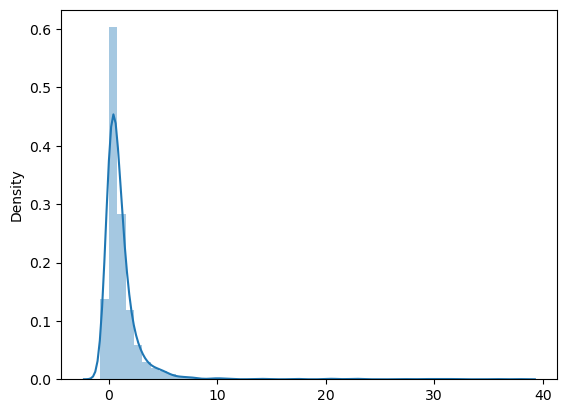

In [79]:
sns.distplot(target_expr)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

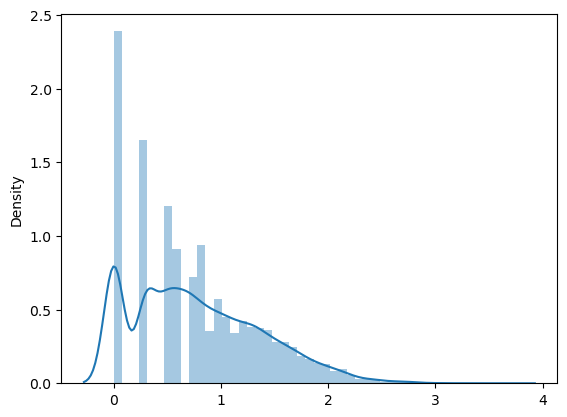

In [80]:
sns.distplot(np.log10(1+ (adj_ps < 0.01).sum(axis=1)))

# First round clustering -- no masking of target (not used in final paper)

In [82]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import *
from scipy.spatial.distance import *
from collections import defaultdict, Counter, OrderedDict

In [83]:
thresholds = np.linspace(0.5, 3, 51)

In [84]:
coefs = raw_coefs.loc[non_control_perturbations]

In [168]:
distance_matrix = pd.DataFrame(pairwise_distances(coefs, metric='correlation', n_jobs=20),
                               index=coefs.index, columns=coefs.index)

In [ ]:
Z = linkage(squareform(distance_matrix.values, checks=False), method='average')
R = inconsistent(Z, d=5)
sns.distplot(pd.DataFrame(R)[3])

## Identify clusters that are gene-driven or sequence-driven

In [170]:
# Define a function to check if a majority of items in a list are the same
def is_majority_same(items):
    counts = Counter(items)
    most_common_count = counts.most_common(1)[0][1]
    if len(items) <= 3:
        return most_common_count == len(items)
    else:
        return most_common_count >= len(items) * 0.75

def is_plurality_same(items):
    counts = Counter(items)
    # Filter out genes with only one sgRNA targeting them
    filtered_counts = {gene: count for gene, count in counts.items() if count > 1}
    plurality_count = sum(filtered_counts.values())
    if len(items) == 2:
        return plurality_count == 2, filtered_counts
    else:
        return plurality_count >= len(items) / 2, filtered_counts

results = defaultdict(dict)
clustered_guides = defaultdict(list)
cluster_labels = defaultdict(pd.Series)
full_clusters = defaultdict(lambda: defaultdict(dict))   

for threshold in thresholds:
    threshold = round(threshold, 1)
    clusters = fcluster(Z, t=threshold, criterion='inconsistent', R=R)
    cluster_labels[threshold] = pd.Series(clusters, index=coefs.index)

    # Link each index in df to its cluster
    cluster_dict = {index: cluster for index, cluster in zip(coefs.index, clusters)}
    
    # Group sgRNAs by gene and by their cluster
    gene_cluster_dict = defaultdict(lambda: defaultdict(list))
    all_clusters_dict = defaultdict(list)  # Store all sgRNAs by their cluster

    for index, cluster in cluster_dict.items():
        gene = index.split('_')[0]
        gene_cluster_dict[gene][cluster].append(index)
        all_clusters_dict[cluster].append(index)  # Store all sgRNAs by cluster

    # Filter clusters having 2 or more sgRNAs from the same gene
    for gene, clusters in gene_cluster_dict.items():
        filtered_clusters = {cluster: sgRNAs for cluster, sgRNAs in clusters.items() if len(sgRNAs) >= 2}
        if filtered_clusters:
            results[threshold][gene] = filtered_clusters
            # Also store the full cluster definition for those clusters that passed the filtering
            for cluster, sgRNAs in filtered_clusters.items():  # Modified line
                full_clusters[threshold][gene][cluster] = all_clusters_dict[cluster]
                clustered_guides[threshold].extend(sgRNAs)  # Append sgRNAs of the filtered cluster to the list

In [171]:
# Dictionary to store cluster classifications
cluster_classifications = defaultdict(dict)
sorted_cluster_classifications = defaultdict(OrderedDict)
gene_driven_guides = defaultdict(list)
sequence_driven_guides = defaultdict(list)
unclustered_guides = defaultdict(list)
encountered_suffixes = defaultdict(Counter)

for threshold in thresholds:
    threshold = round(threshold, 1)
    clusters = fcluster(Z, t=threshold, criterion='inconsistent', R=R)
    
    # Group sgRNAs by their cluster
    cluster_dict = defaultdict(list)
    for index, cluster in zip(coefs.index, clusters):
        cluster_dict[cluster].append(index)
    
    for cluster, sgRNAs in cluster_dict.items():
        if len(sgRNAs) <= 1:  # Skip singleton clusters
            cluster_classifications[threshold][cluster] = f'singleton ({sgRNAs[0][-5:]}) ({len(sgRNAs)})'
            continue

        genes = [sgRNA.split('_')[0] for sgRNA in sgRNAs]
        
        is_gene_driven, gene_counts = is_plurality_same(genes)
        sequence_driven_suffix = None
        
        # Check for SEQUENCE-driven by different suffix lengths (6 to 3)
        for suffix_length in range(10, 2, -1):
            sequences_end = [sgRNA[-suffix_length:] for sgRNA in sgRNAs]
            if is_majority_same(sequences_end):
                sequence_driven_suffix = Counter(sequences_end).most_common(1)[0][0]
                break  # Found a majority with current suffix length, break the loop
        
        # Classify the cluster based on the results
        gene_prefix = 'multi-' if len(gene_counts) > 1 else ''
        if is_gene_driven and sequence_driven_suffix:
            gene_list = ', '.join([f'{gene}({count})' for gene, count in gene_counts.items()])
            encountered_suffixes[threshold][sequence_driven_suffix] += len([sg for sg in sgRNAs if sg.endswith(sequence_driven_suffix)])
            cluster_classifications[threshold][cluster] = f'{cluster}: both (SEQUENCE-driven {sequence_driven_suffix}) {gene_prefix}GENE-driven ({gene_list}) ({len(sgRNAs)})'
            gene_driven_guides[threshold].extend(sgRNAs)
            sequence_driven_guides[threshold].extend(sgRNAs)
        elif is_gene_driven:
            gene_list = ', '.join([f'{gene}({count})' for gene, count in gene_counts.items()])
            cluster_classifications[threshold][cluster] = f'{cluster}: {gene_prefix}GENE-driven ({gene_list}) ({len(sgRNAs)})'
            gene_driven_guides[threshold].extend(sgRNAs)
        elif sequence_driven_suffix:
            encountered_suffixes[threshold][sequence_driven_suffix] += len([sg for sg in sgRNAs if sg.endswith(sequence_driven_suffix)])
            cluster_classifications[threshold][cluster] = f'{cluster}: SEQUENCE-driven ({sequence_driven_suffix}) ({len(sgRNAs)})'
            sequence_driven_guides[threshold].extend(sgRNAs)
            
        else:
            cluster_classifications[threshold][cluster] = f'{cluster}: neither ({len(sgRNAs)})'
            unclustered_guides[threshold].extend(sgRNAs)
    
    sorted_clusters = sorted(cluster_classifications[threshold].items(), key=lambda item: item[0])
    sorted_cluster_classifications[threshold] = pd.Series(OrderedDict(sorted_clusters))

## Look for gene-driven clusters that arise earliest when traversing linkage (not used in final paper)

In [172]:
def check_common_suffix(sgRNAs, max_suffix_length=10):
    for suffix_length in range(max_suffix_length, 2, -1):
        sequences_end = [sgRNA[-suffix_length:] for sgRNA in sgRNAs]
        has_common_suffix = is_majority_same(sequences_end)
        if has_common_suffix:
            return Counter(sequences_end).most_common(1)[0][0]
    return None

cluster_sizes = {
    threshold: clusters.map(clusters.value_counts())
    for threshold, clusters in cluster_labels.items()
}

# Extract genes and initialize data structures
genes = coefs.index.map(lambda x: x.split('_')[0])
n = len(coefs)
gene_cluster_info = {gene: {'threshold': np.inf, 'cluster_size': 0, 'cluster_composition': set(), 'unique_genes_count': 0} for gene in set(genes)}
index_to_cluster = {i: i for i in range(n)}  # Map from original index to current cluster ID

for i, row in enumerate(Z):
    cluster1, cluster2, distance, _ = row
    cluster1, cluster2 = int(cluster1), int(cluster2)

    # Find which genes are in each of the two clusters being merged
    genes_in_cluster1 = set(genes[j] for j in index_to_cluster if index_to_cluster[j] == cluster1)
    genes_in_cluster2 = set(genes[j] for j in index_to_cluster if index_to_cluster[j] == cluster2)

    # Update the cluster IDs
    new_cluster_id = n + i
    for j in index_to_cluster:
        if index_to_cluster[j] in [cluster1, cluster2]:
            index_to_cluster[j] = new_cluster_id

    # Check if any gene has sgRNAs in both clusters
    for gene in genes_in_cluster1.intersection(genes_in_cluster2):
        if gene_cluster_info[gene]['threshold'] == np.inf:
            gene_cluster_info[gene]['threshold'] = distance
            # Update to include the total size of the new cluster
            gene_cluster_info[gene]['cluster_size'] = sum(1 for j in index_to_cluster if index_to_cluster[j] == new_cluster_id)
            # Update the cluster composition according to the labels in coefs.index
            gene_cluster_info[gene]['cluster_composition'] = {coefs.index[j] for j in index_to_cluster if index_to_cluster[j] == new_cluster_id}
            # Count the number of unique genes represented in the cluster
            gene_cluster_info[gene]['unique_genes_count'] = len(set(genes[j] for j in index_to_cluster if index_to_cluster[j] == new_cluster_id))
            
            common_suffix = check_common_suffix(list(gene_cluster_info[gene]['cluster_composition']))
            gene_cluster_info[gene]['common_suffix'] = common_suffix

In [173]:
gene_cluster_info = pd.DataFrame(gene_cluster_info).T

In [174]:
gene_cluster_info.query('cluster_size < 20 and unique_genes_count < 5').sort_values('threshold')

,threshold,cluster_size,cluster_composition,unique_genes_count,common_suffix
CCN3,0.066153,2,"{CCN3_GGGGAAGTGGAACGAACCCC, CCN3_GGCCCCGGCGCCG...",1,None
HES4,0.103397,2,"{HES4_GCGGCCTCCGCGGGCGACAA, HES4_GCCCCCCTCCGAC...",1,None
FOXC2,0.136387,2,"{FOXC2_GAGAGGAGTCGGCGCCAATC, FOXC2_GGAGGAGTCGG...",1,None
MYRF,0.18657,2,"{MYRF_GCGGGGCCGTCCCGGGTCGG, MYRF_GAGCGCCGCCTGC...",1,None
MYC,0.202671,2,"{MYC_GGCCGCGAGCAGCACAGCTC, MYC_GTCCCCTCCTGCCTC...",1,None
...,...,...,...,...,...
ZNF70,0.926193,2,"{ZNF70_GGGACACAAGGACCCGAATC, ZNF70_GCTAGGCCGCG...",1,None
ID1,0.932703,2,"{ID1_GAACAGCAAGGGTGGGTCGG, ID1_GCGAGCAGGAGGCTG...",1,None
AATF,0.942414,2,"{AATF_GGAAGCGCGCAGAAGGTTGA, AATF_GGAAGGGATTGGA...",1,None
ZNF516,0.945031,3,"{FOXD4L4_GCAAGAAGCAGGAACGCTAG, ZNF516_GCGCCCCT...",2,None


In [175]:
gene_cluster_info.query('cluster_size < 20 and unique_genes_count < 5').sort_values('threshold')

,threshold,cluster_size,cluster_composition,unique_genes_count,common_suffix
CCN3,0.066153,2,"{CCN3_GGGGAAGTGGAACGAACCCC, CCN3_GGCCCCGGCGCCG...",1,None
HES4,0.103397,2,"{HES4_GCGGCCTCCGCGGGCGACAA, HES4_GCCCCCCTCCGAC...",1,None
FOXC2,0.136387,2,"{FOXC2_GAGAGGAGTCGGCGCCAATC, FOXC2_GGAGGAGTCGG...",1,None
MYRF,0.18657,2,"{MYRF_GCGGGGCCGTCCCGGGTCGG, MYRF_GAGCGCCGCCTGC...",1,None
MYC,0.202671,2,"{MYC_GGCCGCGAGCAGCACAGCTC, MYC_GTCCCCTCCTGCCTC...",1,None
...,...,...,...,...,...
ZNF70,0.926193,2,"{ZNF70_GGGACACAAGGACCCGAATC, ZNF70_GCTAGGCCGCG...",1,None
ID1,0.932703,2,"{ID1_GAACAGCAAGGGTGGGTCGG, ID1_GCGAGCAGGAGGCTG...",1,None
AATF,0.942414,2,"{AATF_GGAAGCGCGCAGAAGGTTGA, AATF_GGAAGGGATTGGA...",1,None
ZNF516,0.945031,3,"{FOXD4L4_GCAAGAAGCAGGAACGCTAG, ZNF516_GCGCCCCT...",2,None


## Look for seed-driven clusters that arise earliest when traversing linkage

In [176]:
from collections import Counter

# Function to get the common suffix of a given length, if exists
def get_common_suffix(seqs, length):
    suffixes = [seq[-length:] for seq in seqs]
    common_suffix = suffixes[0]
    if all(suffix == common_suffix for suffix in suffixes):
        return common_suffix
    return None

# Extract the sequences and initialize data structures
seqs = coefs.index.tolist()
n = len(seqs)
seq_cluster_info = {}
index_to_cluster = {i: i for i in range(n)}  # Map from original index to current cluster ID

for i, row in enumerate(Z):
    cluster1, cluster2, distance, _ = row
    cluster1, cluster2 = int(cluster1), int(cluster2)

    # Update the cluster IDs
    new_cluster_id = n + i
    for j in index_to_cluster:
        if index_to_cluster[j] in [cluster1, cluster2]:
            index_to_cluster[j] = new_cluster_id

    # Get all sequences in the new cluster
    seqs_in_new_cluster = [seqs[j] for j in index_to_cluster if index_to_cluster[j] == new_cluster_id]
    
    # Proceed only if cluster size is 4 or more
    if len(seqs_in_new_cluster) >= 4:
        # Check for common suffixes starting from longest (8) to shortest (3)
        for length in range(8, 2, -1):  # Start from 8, decrement to 3
            common_suffix = get_common_suffix(seqs_in_new_cluster, length)
            if common_suffix:
                key = f'seed_{common_suffix}'
                if key not in seq_cluster_info:
                    # Count total sgRNAs in coefs.index ending with the seed
                    total_sgRNAs_with_seed = sum(1 for seq in seqs if seq.endswith(common_suffix))

                    seq_cluster_info[key] = {'threshold': distance,
                                               'cluster_size': len(seqs_in_new_cluster),
                                               'cluster_entries': seqs_in_new_cluster,
                                               'total_sgRNAs_with_seed': total_sgRNAs_with_seed}
                break  # Break after finding the longest common suffix

seq_cluster_info = pd.DataFrame(seq_cluster_info).T

In [177]:
seq_cluster_info

,threshold,cluster_size,cluster_entries,total_sgRNAs_with_seed
seed_TCCTG,0.156446,4,"[BHLHE22_GGCGAAGCCTGGGAGTCCTG, GLIS2_GGCAGTGGC...",16
seed_CTGGAG,0.244145,4,"[ERG_GCAGCACGCGACTACTGGAG, SMARCA4_GCAGGCGGCGG...",14
seed_TGGAG,0.253603,5,"[DHX9_GCGAGGGCGCGCCAATGGAG, ERG_GCAGCACGCGACTA...",27
seed_CGGCGG,0.267869,4,"[HIVEP1_GGGGAACCAGCACACGGCGG, MLLT10_GCCCCAGCA...",13
seed_GGCGG,0.289042,5,"[HIVEP1_GGGGAACCAGCACACGGCGG, HOXA1_GCCCCAGGCA...",45
...,...,...,...,...
seed_CTCC,0.933695,5,"[AFF4_GCACCCCGGGCGTCGCCTCC, FGF3_GACGCCCCCGAAA...",61
seed_ACT,0.933713,5,"[BDP1_GACGTCAGACGCACAGCACT, CTBP2_GGCCCTCCCAAG...",88
seed_AAGAGC,0.935967,4,"[REPIN1_GGGGCGCCCCCGCCAAGAGC, ZNF205_GTCACCTCC...",6
seed_TCC,0.952998,9,"[AFF4_GCACCCCGGGCGTCGCCTCC, FGF3_GACGCCCCCGAAA...",174


In [178]:
import dill, pickle

In [179]:
variables = {"results": results,
             "cluster_labels": cluster_labels,
             "full_clusters": full_clusters,
             "sequence_driven_guides": sequence_driven_guides,
             "gene_driven_guides": gene_driven_guides,
             "sorted_cluster_classifications": sorted_cluster_classifications,
             "gene_cluster_info": gene_cluster_info,
             "seq_cluster_info": seq_cluster_info,
             }

In [180]:
with open(PREFIX + 'variables.pickle', 'wb') as handle:
    dill.dump(variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Identifying active guides and properties of clusters defining them (not used in final paper--see masked analysis below)

In [181]:
from functools import reduce

all_clustered = {k:v for k,v in results[1.4].items() if (('non-targeting' not in k) and ('off-target' not in k))}

all_clustered = list(map(lambda x: reduce(np.union1d, list(x.values())), list(all_clustered.values())))
all_clustered = [list(v) for v in all_clustered]
all_clustered = reduce(np.union1d, all_clustered)

In [182]:
guide_library = feature_library[['sequence', 'name']].copy()

guide_library.columns = ['protospacer', 'target_gene']
guide_library.loc[guide_library.index.str.contains('off-target'), 'target_gene'] = 'off-target'

guide_library['target_expr'] = target_expr

guide_library['active'] = guide_library.index.isin(all_clustered)
guide_library['cluster'] = cluster_labels[1.4]

In [183]:
cluster_namer = guide_library.query('active').sort_values('cluster').groupby(['target_gene', 'cluster']).head(1)[['target_gene', 'cluster']]
cluster_namer['index'] = cluster_namer.groupby('target_gene').rank(method="first", ascending=True).astype(int)
cluster_namer['name'] = cluster_namer['target_gene'] + '_' + cluster_namer['index'].astype(str)
cluster_namer = cluster_namer.set_index(['target_gene', 'cluster'])['name']
guide_library['cluster_name'] = guide_library.query('active').apply(lambda x: cluster_namer.loc[(x['target_gene'], x['cluster'])], axis=1)
guide_library['cluster_description'] = guide_library['cluster'].map(sorted_cluster_classifications[1.4])

In [184]:
guide_library['gene_driven'] = guide_library.index.isin(gene_driven_guides[1.4])
guide_library['sequence_driven'] = guide_library.index.isin(sequence_driven_guides[1.4])

suffix_mapper = sorted_cluster_classifications[1.4][sorted_cluster_classifications[1.4].str.contains('SEQUENCE')].str.extract(r'\((.*?)\)')[0]
guide_library['sequence_suffix'] = guide_library['cluster'].map(lambda x: suffix_mapper.get(x, ''))

# Defining whether target genes are expressed based on paired bulk RNA-seq data

In [185]:
rpe1_bulk_expr = pd.read_csv('/data/norman/southark/datasets/Project_14718/pipeline/counts/gene_counts_name.txt', sep='\t', skiprows=1, index_col=0)
rpe1_bulk_expr = rpe1_bulk_expr.loc[:, rpe1_bulk_expr.columns.str.contains('T1_cycling')].mean(axis=1)

guide_library['bulk_expr'] = pd.Series(rpe1_bulk_expr.reindex(guide_library['target_gene']).values, index=guide_library.index)

In [186]:
from sklearn.mixture import GaussianMixture


In [187]:
def classify_and_plot(data_series):
    """
    Classifies the data using a Gaussian Mixture Model and plots the results.
    Args:
    data_series (pd.Series): Pandas Series containing the data.
    """
    # Remove entries with zero values
    non_zero_data = data_series[data_series != 0]

    # Log-transform the non-zero data
    log_data = np.log(non_zero_data).values.reshape(-1, 1)

    # Fit GMM
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(log_data)

    # Determine which component is the higher mode and adjust classifications and probabilities
    higher_mode_label = np.argmax(gmm.means_)
    classifications = gmm.predict(log_data)
    probabilities = gmm.predict_proba(log_data)

    if higher_mode_label == 0:
        probabilities = probabilities[:, [1, 0]]
        classifications = 1 - classifications  # Swapping 0s and 1s in classifications

    # Prepare final results as pandas series
    final_classifications = pd.Series(np.zeros(len(data_series), dtype=int), index=data_series.index)
    final_probabilities = pd.DataFrame(np.zeros((len(data_series), 2)), index=data_series.index)

    # Assign the classifications and probabilities to non-zero data points
    final_classifications.loc[non_zero_data.index] = classifications
    final_probabilities.loc[non_zero_data.index] = probabilities

    # Plotting
    plt.figure(figsize=(10, 6))

    # Histogram of the log-transformed data
    plt.hist(log_data, bins=30, density=True, alpha=0.6, color='g')

    # Plot each Gaussian component
    x = np.linspace(log_data.min(), log_data.max(), 1000).reshape(-1, 1)
    for mean, covar, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        pdf = weight * np.exp(-0.5 * (x - mean) ** 2 / covar) / np.sqrt(2 * np.pi * covar)
        plt.plot(x, pdf.ravel(), linewidth=2)

    # Combined GMM PDF
    logspace = np.linspace(log_data.min(), log_data.max(), 1000)
    pdf_total = np.exp(gmm.score_samples(logspace.reshape(-1, 1)))
    plt.plot(logspace, pdf_total, color='red', linewidth=3, label='GMM Total')

    plt.title('Histogram and Gaussian Mixture Model')
    plt.xlabel('Log-Transformed Data')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return final_classifications, final_probabilities

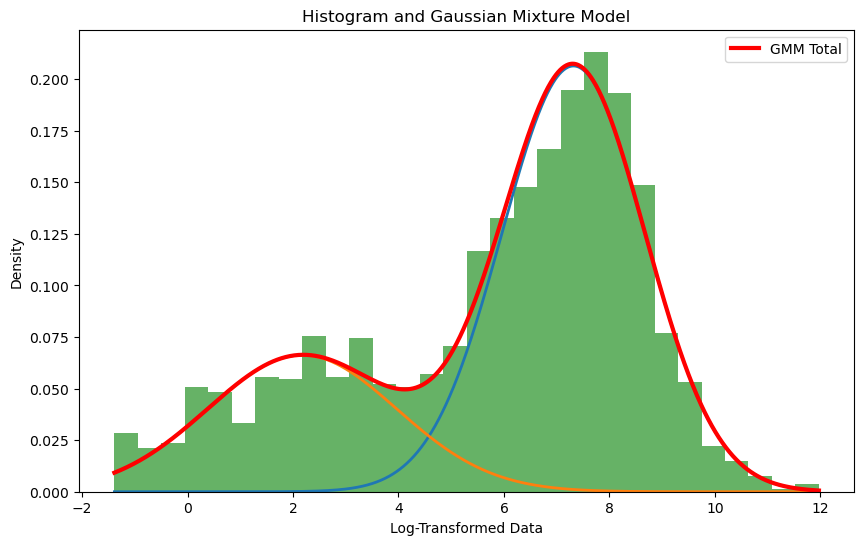

In [188]:
final_classifications, final_probabilities = classify_and_plot(guide_library.groupby('target_gene').head(1)[['bulk_expr', 'target_gene']].set_index('target_gene')['bulk_expr'].dropna())
guide_library['expressed'] = guide_library['target_gene'].map(final_classifications).astype(bool)
guide_library['p_expressed'] = guide_library['target_gene'].map(final_probabilities[1])

In [189]:
guide_library['de_genes'] = (adj_ps < 0.05).sum(axis=1)
guide_library['strength'] = (coefs*(adj_ps < 0.05)).abs().sum(axis=1)
guide_library['cell_count'] = cell_counts.astype(int)

In [190]:
gene_list = guide_library['target_gene'].unique()

In [191]:
import mygene
mg = mygene.MyGeneInfo()

# Querying for Ensembl IDs
result = mg.querymany(gene_list, scopes='symbol', fields='ensembl.gene', species='human')

# Mapping gene symbols to Ensembl IDs
gene_to_ensembl = {}
for gene in result:
    if 'ensembl' in gene:
        if isinstance(gene['ensembl'], list):  # Handle multiple Ensembl IDs case
            gene_to_ensembl[gene['query']] = [ensembl['gene'] for ensembl in gene['ensembl']]
        else:
            gene_to_ensembl[gene['query']] = gene['ensembl']['gene']
    else:
        gene_to_ensembl[gene['query']] = None  # No Ensembl ID found

# Print the dictionary
for symbol, ensembl_id in gene_to_ensembl.items():
    print(f"{symbol}: {ensembl_id}")


querying 1-1000...done.
querying 1001-1838...done.
Finished.
3 input query terms found dup hits:
	[('BORCS8-MEF2B', 2), ('ZNF286B', 2), ('ZNF781', 2)]
5 input query terms found no hit:
	['ARNTL', 'ARNTL2', 'T', 'non-targeting', 'off-target']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
AATF: ['ENSG00000275700', 'ENSG00000276072']
ABL1: ENSG00000097007
ACTL6A: ENSG00000136518
ADAR: ENSG00000160710
ADNP: ENSG00000101126
ADNP2: ENSG00000101544
AEBP2: ENSG00000139154
AFF1: ENSG00000172493
AFF2: ENSG00000155966
AFF3: ENSG00000144218
AFF4: ENSG00000072364
AHR: ENSG00000106546
AHRR: ENSG00000063438
AIRE: ENSG00000160224
AKNA: ENSG00000106948
ALX1: ENSG00000180318
ALX3: ENSG00000156150
ALX4: ENSG00000052850
ALYREF: ENSG00000183684
ANHX: ENSG00000227059
ANKRD30A: ENSG00000148513
AP2B1: ENSG00000006125
APEX1: ['ENSG00000291796', 'ENSG00000100823']
AR: ENSG00000169083
ARGFX: ENSG00000186103
ARHGAP35: ENSG00000160007
ARID1A: ENSG00000117713
ARID1B: ENSG000000

In [192]:
manual_updates = {'ARNTL': 'ENSG00000133794',
                  'ARNTL2': 'ENSG00000029153',
                 'ATF6B':'ENSG00000213676',
                 'HBP1': 'ENSG00000105856',
                 'PBX2': 'ENSG00000204304',
                 'PCGF2':'ENSG00000277258',
                 'PHF1':'ENSG00000112511',
                 'RFX1':'ENSG00000132005',
                 'TCF20':'ENSG00000100207',
                 'TIGD5':'ENSG00000179886',
                 'TWIST2': 'ENSG00000233608',
                 'ZBTB4':'ENSG00000174282',
                 'ZNF280D':'ENSG00000137871',
                 'ZNF35':'ENSG00000169981'}

# Merging the manual updates into gene_to_ensembl
for gene, ensembl_id in manual_updates.items():
    if gene in gene_to_ensembl:
        existing_entry = gene_to_ensembl[gene]
        if isinstance(existing_entry, list):
            if ensembl_id not in existing_entry:
                existing_entry.append(ensembl_id)  # Add new Ensembl ID to the list
        elif existing_entry != ensembl_id:
            gene_to_ensembl[gene] = [existing_entry, ensembl_id]  # Create a list with both IDs
    else:
        gene_to_ensembl[gene] = ensembl_id  # Add new gene symbol and its Ensembl ID

In [193]:
# Assuming coefs.columns is your list of detected Ensembl IDs
detected_ensembl_ids = set(coefs.columns)

# Filter the gene_to_ensembl dictionary
filtered_gene_to_ensembl = {}
for gene, ensembl_ids in gene_to_ensembl.items():
    if isinstance(ensembl_ids, list):
        # Filter to keep only detected Ensembl IDs
        detected_ids = [eid for eid in ensembl_ids if eid in detected_ensembl_ids]
        if len(detected_ids) == 1:
            # If there's only one detected ID, store it directly
            filtered_gene_to_ensembl[gene] = detected_ids[0]
        elif detected_ids:
            # If there are multiple, store them as a list
            filtered_gene_to_ensembl[gene] = detected_ids
    elif ensembl_ids and ensembl_ids in detected_ensembl_ids:
        # For a single Ensembl ID
        filtered_gene_to_ensembl[gene] = ensembl_ids

# Print the filtered dictionary
for symbol, ensembl_id in filtered_gene_to_ensembl.items():
    print(f"{symbol}: {ensembl_id}")

AATF: ENSG00000275700
ABL1: ENSG00000097007
ACTL6A: ENSG00000136518
ADAR: ENSG00000160710
ADNP: ENSG00000101126
AFF3: ENSG00000144218
AFF4: ENSG00000072364
AHR: ENSG00000106546
ALYREF: ENSG00000183684
AP2B1: ENSG00000006125
APEX1: ENSG00000100823
ARHGAP35: ENSG00000160007
ARID1A: ENSG00000117713
ARID1B: ENSG00000049618
ARID4B: ENSG00000054267
ARID5B: ENSG00000150347
ASH1L: ENSG00000116539
ATF4: ENSG00000128272
ATF5: ENSG00000169136
ATF6: ENSG00000118217
ATF6B: ENSG00000213676
ATF7: ENSG00000170653
ATMIN: ENSG00000166454
ATOH8: ENSG00000168874
BACH1: ENSG00000156273
BAZ1B: ENSG00000009954
BAZ2A: ENSG00000076108
BAZ2B: ENSG00000123636
BBX: ENSG00000114439
BCL3: ENSG00000069399
BCLAF1: ENSG00000029363
BDP1: ENSG00000145734
BHLHE41: ENSG00000123095
BID: ENSG00000015475
BNC2: ENSG00000173068
BNIP3: ENSG00000176171
BPTF: ENSG00000171634
BRCA1: ENSG00000012048
CAMTA1: ENSG00000171735
CARHSP1: ENSG00000153048
CBFB: ENSG00000067955
CCN3: ENSG00000136999
CCNH: ENSG00000134480
CDC5L: ENSG00000096

In [194]:
guide_library['target_gene_id'] = guide_library['target_gene'].map(filtered_gene_to_ensembl)

# Now repeat all these analyses but with target gene masked with NaN


In [195]:
masked_coefs = coefs.copy()
masked_coefs['target_gene_id'] = masked_coefs.index.map(lambda x: x.split('_')[0]).map(filtered_gene_to_ensembl).fillna('')
masked_coefs.set_index('target_gene_id', append=True, inplace=True)

# Iterate over the rows of the DataFrame
for row_index, row_data in tqdm(masked_coefs.iterrows()):
    # Extracting the Ensembl ID from the second level of the multi-index
    target_gene_id = row_index[1]

    # Check if the Ensembl ID is not an empty string
    if target_gene_id != "":
        # Set the corresponding column's value to np.nan
        if target_gene_id in masked_coefs.columns:
            masked_coefs.at[row_index, target_gene_id] = np.nan
            
masked_coefs = masked_coefs.droplevel(1)

0it [00:00, ?it/s]

In [196]:
from nancorrmp.nancorrmp import NaNCorrMp

In [197]:
thresholds = np.linspace(0.5, 3, 51)

In [218]:
distance_matrix = 1 - NaNCorrMp.calculate(masked_coefs.T, n_jobs=20)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='3', ylabel='Density'>

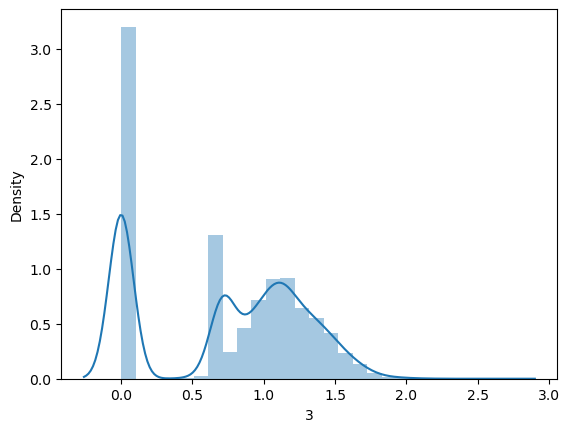

In [199]:
Z = linkage(squareform(distance_matrix.values, checks=False), method='average')
R = inconsistent(Z, d=5)
sns.distplot(pd.DataFrame(R)[3])

In [200]:
# Define a function to check if a majority of items in a list are the same
def is_majority_same(items):
    counts = Counter(items)
    most_common_count = counts.most_common(1)[0][1]
    if len(items) <= 3:
        return most_common_count == len(items)
    else:
        return most_common_count >= len(items) * 0.75

def is_plurality_same(items):
    counts = Counter(items)
    # Filter out genes with only one sgRNA targeting them
    filtered_counts = {gene: count for gene, count in counts.items() if count > 1}
    plurality_count = sum(filtered_counts.values())
    if len(items) == 2:
        return plurality_count == 2, filtered_counts
    else:
        return plurality_count >= len(items) / 2, filtered_counts

results = defaultdict(dict)
clustered_guides = defaultdict(list)
cluster_labels = defaultdict(pd.Series)
full_clusters = defaultdict(lambda: defaultdict(dict))   

for threshold in thresholds:
    threshold = round(threshold, 1)
    clusters = fcluster(Z, t=threshold, criterion='inconsistent', R=R)
    cluster_labels[threshold] = pd.Series(clusters, index=coefs.index)

    # Link each index in df to its cluster
    cluster_dict = {index: cluster for index, cluster in zip(coefs.index, clusters)}
    
    # Group sgRNAs by gene and by their cluster
    gene_cluster_dict = defaultdict(lambda: defaultdict(list))
    all_clusters_dict = defaultdict(list)  # Store all sgRNAs by their cluster

    for index, cluster in cluster_dict.items():
        gene = index.split('_')[0]
        gene_cluster_dict[gene][cluster].append(index)
        all_clusters_dict[cluster].append(index)  # Store all sgRNAs by cluster

    # Filter clusters having 2 or more sgRNAs from the same gene
    for gene, clusters in gene_cluster_dict.items():
        filtered_clusters = {cluster: sgRNAs for cluster, sgRNAs in clusters.items() if len(sgRNAs) >= 2}
        if filtered_clusters:
            results[threshold][gene] = filtered_clusters
            # Also store the full cluster definition for those clusters that passed the filtering
            for cluster, sgRNAs in filtered_clusters.items():  # Modified line
                full_clusters[threshold][gene][cluster] = all_clusters_dict[cluster]
                clustered_guides[threshold].extend(sgRNAs)  # Append sgRNAs of the filtered cluster to the list

In [201]:
# Dictionary to store cluster classifications
cluster_classifications = defaultdict(dict)
sorted_cluster_classifications = defaultdict(OrderedDict)
gene_driven_guides = defaultdict(list)
sequence_driven_guides = defaultdict(list)
unclustered_guides = defaultdict(list)
encountered_suffixes = defaultdict(Counter)

for threshold in thresholds:
    threshold = round(threshold, 1)
    clusters = fcluster(Z, t=threshold, criterion='inconsistent', R=R)
    
    # Group sgRNAs by their cluster
    cluster_dict = defaultdict(list)
    for index, cluster in zip(coefs.index, clusters):
        cluster_dict[cluster].append(index)
    
    for cluster, sgRNAs in cluster_dict.items():
        if len(sgRNAs) <= 1:  # Skip singleton clusters
            cluster_classifications[threshold][cluster] = f'singleton ({sgRNAs[0][-5:]}) ({len(sgRNAs)})'
            continue

        genes = [sgRNA.split('_')[0] for sgRNA in sgRNAs]
        
        is_gene_driven, gene_counts = is_plurality_same(genes)
        sequence_driven_suffix = None
        
        # Check for SEQUENCE-driven by different suffix lengths (6 to 3)
        for suffix_length in range(10, 2, -1):
            sequences_end = [sgRNA[-suffix_length:] for sgRNA in sgRNAs]
            if is_majority_same(sequences_end):
                sequence_driven_suffix = Counter(sequences_end).most_common(1)[0][0]
                break  # Found a majority with current suffix length, break the loop
        
        # Classify the cluster based on the results
        gene_prefix = 'multi-' if len(gene_counts) > 1 else ''
        if is_gene_driven and sequence_driven_suffix:
            gene_list = ', '.join([f'{gene}({count})' for gene, count in gene_counts.items()])
            encountered_suffixes[threshold][sequence_driven_suffix] += len([sg for sg in sgRNAs if sg.endswith(sequence_driven_suffix)])
            cluster_classifications[threshold][cluster] = f'{cluster}: both (SEQUENCE-driven {sequence_driven_suffix}) {gene_prefix}GENE-driven ({gene_list}) ({len(sgRNAs)})'
            gene_driven_guides[threshold].extend(sgRNAs)
            sequence_driven_guides[threshold].extend(sgRNAs)
        elif is_gene_driven:
            gene_list = ', '.join([f'{gene}({count})' for gene, count in gene_counts.items()])
            cluster_classifications[threshold][cluster] = f'{cluster}: {gene_prefix}GENE-driven ({gene_list}) ({len(sgRNAs)})'
            gene_driven_guides[threshold].extend(sgRNAs)
        elif sequence_driven_suffix:
            encountered_suffixes[threshold][sequence_driven_suffix] += len([sg for sg in sgRNAs if sg.endswith(sequence_driven_suffix)])
            cluster_classifications[threshold][cluster] = f'{cluster}: SEQUENCE-driven ({sequence_driven_suffix}) ({len(sgRNAs)})'
            sequence_driven_guides[threshold].extend(sgRNAs)
            
        else:
            cluster_classifications[threshold][cluster] = f'{cluster}: neither ({len(sgRNAs)})'
            unclustered_guides[threshold].extend(sgRNAs)
    
    sorted_clusters = sorted(cluster_classifications[threshold].items(), key=lambda item: item[0])
    sorted_cluster_classifications[threshold] = pd.Series(OrderedDict(sorted_clusters))

In [202]:
def check_common_suffix(sgRNAs, max_suffix_length=10):
    for suffix_length in range(max_suffix_length, 2, -1):
        sequences_end = [sgRNA[-suffix_length:] for sgRNA in sgRNAs]
        has_common_suffix = is_majority_same(sequences_end)
        if has_common_suffix:
            return Counter(sequences_end).most_common(1)[0][0]
    return None

cluster_sizes = {
    threshold: clusters.map(clusters.value_counts())
    for threshold, clusters in cluster_labels.items()
}

# Extract genes and initialize data structures
genes = coefs.index.map(lambda x: x.split('_')[0])
n = len(coefs)
gene_cluster_info = {gene: {'threshold': np.inf, 'cluster_size': 0, 'cluster_composition': set(), 'unique_genes_count': 0} for gene in set(genes)}
index_to_cluster = {i: i for i in range(n)}  # Map from original index to current cluster ID

for i, row in enumerate(Z):
    cluster1, cluster2, distance, _ = row
    cluster1, cluster2 = int(cluster1), int(cluster2)

    # Find which genes are in each of the two clusters being merged
    genes_in_cluster1 = set(genes[j] for j in index_to_cluster if index_to_cluster[j] == cluster1)
    genes_in_cluster2 = set(genes[j] for j in index_to_cluster if index_to_cluster[j] == cluster2)

    # Update the cluster IDs
    new_cluster_id = n + i
    for j in index_to_cluster:
        if index_to_cluster[j] in [cluster1, cluster2]:
            index_to_cluster[j] = new_cluster_id

    # Check if any gene has sgRNAs in both clusters
    for gene in genes_in_cluster1.intersection(genes_in_cluster2):
        if gene_cluster_info[gene]['threshold'] == np.inf:
            gene_cluster_info[gene]['threshold'] = distance
            # Update to include the total size of the new cluster
            gene_cluster_info[gene]['cluster_size'] = sum(1 for j in index_to_cluster if index_to_cluster[j] == new_cluster_id)
            # Update the cluster composition according to the labels in coefs.index
            gene_cluster_info[gene]['cluster_composition'] = {coefs.index[j] for j in index_to_cluster if index_to_cluster[j] == new_cluster_id}
            # Count the number of unique genes represented in the cluster
            gene_cluster_info[gene]['unique_genes_count'] = len(set(genes[j] for j in index_to_cluster if index_to_cluster[j] == new_cluster_id))
            
            common_suffix = check_common_suffix(list(gene_cluster_info[gene]['cluster_composition']))
            gene_cluster_info[gene]['common_suffix'] = common_suffix

In [203]:
gene_cluster_info = pd.DataFrame(gene_cluster_info).T

In [204]:
gene_cluster_info.query('cluster_size < 20 and unique_genes_count < 5').sort_values('threshold')

,threshold,cluster_size,cluster_composition,unique_genes_count,common_suffix
FOXC2,0.141499,2,"{FOXC2_GAGAGGAGTCGGCGCCAATC, FOXC2_GGAGGAGTCGG...",1,None
MYRF,0.18657,2,"{MYRF_GCGGGGCCGTCCCGGGTCGG, MYRF_GAGCGCCGCCTGC...",1,None
MYC,0.203295,2,"{MYC_GGCCGCGAGCAGCACAGCTC, MYC_GTCCCCTCCTGCCTC...",1,None
EOMES,0.221346,2,"{EOMES_GGTCGGCAGGTGGGTAGCCC, EOMES_GGCAGTAGCGG...",1,None
PRDM16,0.233707,2,"{PRDM16_GCGGCGGCGGCGCGACGATG, PRDM16_GTCAATCTG...",1,None
...,...,...,...,...,...
FOXK1,0.920074,2,"{FOXK1_GAACCCGGGCCAGATCGCGC, FOXK1_GTCCCCCTGGA...",1,None
ZNF140,0.923061,2,"{ZNF140_GCTGCCGTGCCCAGAACGCC, ZNF140_GGGCCTGGT...",1,None
ZBTB18,0.924562,2,"{ZBTB18_GAGTGTAGAGGAGTAGCATA, ZBTB18_GAGTAGCAT...",1,None
GATAD2B,0.929885,4,"{GATAD2B_GTGGCCGAGAAGATGAGGGC, SS18_GGCCCATAAG...",3,None


In [205]:
import numpy as np
import pandas as pd
from collections import Counter

# Function to get the common suffix of a given length, if exists
def get_common_suffix(seqs, length):
    suffixes = [seq[-length:] for seq in seqs]
    common_suffix = suffixes[0]
    if all(suffix == common_suffix for suffix in suffixes):
        return common_suffix
    return None

# Extract the sequences and initialize data structures
seqs = coefs.index.tolist()
n = len(seqs)
seq_cluster_info = {}
index_to_cluster = {i: i for i in range(n)}  # Map from original index to current cluster ID

for i, row in enumerate(Z):
    cluster1, cluster2, distance, _ = row
    cluster1, cluster2 = int(cluster1), int(cluster2)

    # Update the cluster IDs
    new_cluster_id = n + i
    for j in index_to_cluster:
        if index_to_cluster[j] in [cluster1, cluster2]:
            index_to_cluster[j] = new_cluster_id

    # Get all sequences in the new cluster
    seqs_in_new_cluster = [seqs[j] for j in index_to_cluster if index_to_cluster[j] == new_cluster_id]
    
    # Proceed only if cluster size is 4 or more
    if len(seqs_in_new_cluster) >= 4:
        # Check for common suffixes starting from longest (8) to shortest (3)
        for length in range(8, 2, -1):  # Start from 8, decrement to 3
            common_suffix = get_common_suffix(seqs_in_new_cluster, length)
            if common_suffix:
                key = f'seed_{common_suffix}'
                if key not in seq_cluster_info:
                    # Count total sgRNAs in coefs.index ending with the seed
                    total_sgRNAs_with_seed = sum(1 for seq in seqs if seq.endswith(common_suffix))

                    seq_cluster_info[key] = {'threshold': distance,
                                               'cluster_size': len(seqs_in_new_cluster),
                                               'cluster_entries': seqs_in_new_cluster,
                                               'total_sgRNAs_with_seed': total_sgRNAs_with_seed}
                break  # Break after finding the longest common suffix

seq_cluster_info = pd.DataFrame(seq_cluster_info).T

In [206]:
seq_cluster_info

,threshold,cluster_size,cluster_entries,total_sgRNAs_with_seed
seed_TCCTG,0.156446,4,"[BHLHE22_GGCGAAGCCTGGGAGTCCTG, GLIS2_GGCAGTGGC...",16
seed_CTGGAG,0.243896,4,"[ERG_GCAGCACGCGACTACTGGAG, SMARCA4_GCAGGCGGCGG...",14
seed_TGGAG,0.253295,5,"[DHX9_GCGAGGGCGCGCCAATGGAG, ERG_GCAGCACGCGACTA...",27
seed_CGGCGG,0.267869,4,"[HIVEP1_GGGGAACCAGCACACGGCGG, MLLT10_GCCCCAGCA...",13
seed_GGCGG,0.289042,5,"[HIVEP1_GGGGAACCAGCACACGGCGG, HOXA1_GCCCCAGGCA...",45
...,...,...,...,...
seed_TCC,0.934893,5,"[AFF4_GCACCCCGGGCGTCGCCTCC, FGF3_GACGCCCCCGAAA...",174
seed_AAGAGC,0.936171,4,"[REPIN1_GGGGCGCCCCCGCCAAGAGC, ZNF205_GTCACCTCC...",6
seed_TCGG,0.943257,4,"[HIC2_GGCAGTGACTGCAAGCTCGG, TFCP2_GATCGCCCAGCC...",110
seed_CGGAA,0.954182,4,"[CRTC2_GCCTGAGACTACGAACGGAA, DHX9_GGCAACCTCGCG...",20


In [207]:
variables = {"results": results,
             "cluster_labels": cluster_labels,
             "full_clusters": full_clusters,
             "sequence_driven_guides": sequence_driven_guides,
             "gene_driven_guides": gene_driven_guides,
             "sorted_cluster_classifications": sorted_cluster_classifications,
             "gene_cluster_info": gene_cluster_info,
             "seq_cluster_info": seq_cluster_info,
             }

In [208]:
with open(PREFIX + 'masked_variables.pickle', 'wb') as handle:
    dill.dump(variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Identifying masked_active guides and properties of clusters defining them

In [209]:
from functools import reduce

all_clustered = {k:v for k,v in results[1.4].items() if (('non-targeting' not in k) and ('off-target' not in k))}

all_clustered = list(map(lambda x: reduce(np.union1d, list(x.values())), list(all_clustered.values())))
all_clustered = [list(v) for v in all_clustered]
all_clustered = reduce(np.union1d, all_clustered)

In [210]:
guide_library['masked_active'] = guide_library.index.isin(all_clustered)
guide_library['masked_cluster'] = cluster_labels[1.4]

In [211]:
cluster_namer = guide_library.query('masked_active').sort_values('masked_cluster').groupby(['target_gene', 'masked_cluster']).head(1)[['target_gene', 'masked_cluster']]
cluster_namer['index'] = cluster_namer.groupby('target_gene').rank(method="first", ascending=True).astype(int)
cluster_namer['name'] = cluster_namer['target_gene'] + '_' + cluster_namer['index'].astype(str)
cluster_namer = cluster_namer.set_index(['target_gene', 'masked_cluster'])['name']
guide_library['masked_cluster_name'] = guide_library.query('masked_active').apply(lambda x: cluster_namer.loc[(x['target_gene'], x['masked_cluster'])], axis=1)

guide_library['masked_cluster_description'] = guide_library['masked_cluster'].map(sorted_cluster_classifications[1.4])
guide_library['masked_cluster_size'] = guide_library['masked_cluster'].map(guide_library.groupby('masked_cluster').size())
guide_library['masked_cluster_num_genes'] = guide_library['masked_cluster'].map(guide_library.groupby(['masked_cluster'])['target_gene'].nunique())

In [212]:
guide_library['stricter_masked_cluster'] = cluster_labels[1.2]
guide_library['stricter_masked_cluster_description'] = guide_library['stricter_masked_cluster'].map(sorted_cluster_classifications[1.2])

In [213]:
guide_library.to_csv(PREFIX + 'guide_library.csv')

# Save results

In [132]:
mean_pop = MeanPopulation(coefs,
                          guide_library.loc[coefs.index],
                          full_pop.genes.loc[coefs.columns], calculate_statistics=False)

Done.


In [133]:
mean_pop.genes['in_matrix'] = True

mean_pop.normalized_matrix = dict()
mean_pop.normalized_matrix['p'] = ps.loc[coefs.index]
mean_pop.normalized_matrix['adj_p'] = adj_ps.loc[coefs.index]
mean_pop.normalized_matrix['masked'] = masked_coefs.loc[coefs.index]

In [123]:
import scanpy as sc

In [124]:
adata = sc.AnnData(X=mean_pop.matrix,
                   obs=mean_pop.cells,
                   var=mean_pop.genes)
adata.layers['p'] = ps.loc[mean_pop.matrix.index]
adata.layers['adj_p'] = adj_ps.loc[mean_pop.matrix.index]
adata.layers['masked'] = masked_coefs.loc[mean_pop.matrix.index]

In [134]:
mean_pop.to_hdf(PREFIX + 'mean_pop.hdf', store_normalized_matrix=True)

Writing matrix...
Writing multiple normalized matrices...
Writing metadata...
! Converting categorical columns to string...
Done in 15.392873287200928s.


/lila/data/norman/tmn/notebooks/droplet overloading/perturbseq/cell_population.py:139: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['protospacer', 'target_gene', 'cluster_name', 'cluster_description',
       'sequence_suffix', 'target_gene_id', 'masked_cluster_name',
       'masked_cluster_description', 'stricter_masked_cluster_description'],
      dtype='object')]

  store.put('cell_list', _strip_cat_cols(self.cells))
/lila/data/norman/tmn/notebooks/droplet overloading/perturbseq/cell_population.py:140: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['gene_name', 'pairwise_chosen'], dtype='object')]

  store.put('gene_list', _strip_cat_cols(self.genes))


In [ ]:
chosen_guides = np.union1d(guide_library.query('masked_active').index, pd.Series(control_guides).map(name_mapper))

In [203]:
full_pop.cells['guide_identity'] = full_pop.cells['guide_identity'].map(name_mapper)

In [205]:
single_cell_pop = full_pop.subpopulation(cells='number_of_cells==1 and guide_identity in @chosen_guides',
                                        chosen_guides=chosen_guides, normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent multiple normalized matrices...


In [208]:
df = guide_library.loc[single_cell_pop.cells['guide_identity']][['target_gene', 'target_gene_id', 'active', 'cluster', 'cluster_name', 'cluster_description',
               'masked_active', 'masked_cluster', 'masked_cluster_name', 'masked_cluster_description',
              'stricter_masked_cluster', 'stricter_masked_cluster_description']]
df.index = single_cell_pop.cells.index

In [209]:
single_cell_pop.cells = single_cell_pop.cells.merge(df, left_index=True, right_index=True)

In [210]:
single_cell_pop.to_hdf('/data/norman/datasets/RA022_Hs27aTFs/cellranger_outputs_additionalseq/combined_guide_calls/20231229_single_cell_pop_tmn.hdf',
                      store_normalized_matrix=True)

Writing matrix...
Writing multiple normalized matrices...
Writing metadata...
Done in 9.378716945648193s.


/lila/data/norman/tmn/notebooks/droplet overloading/perturbseq/cell_population.py:139: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['dataset', 'guide_identity', 'thresholded_features',
       'thresholded_guide_umi', 'guide_target', 'target_gene',
       'target_gene_id', 'cluster_name', 'cluster_description',
       'masked_cluster_name', 'masked_cluster_description',
       'stricter_masked_cluster_description'],
      dtype='object')]

  store.put('cell_list', _strip_cat_cols(self.cells))


In [41]:
guide_library = pd.read_csv(PREFIX + 'guide_library.csv', index_col=0)

In [50]:
single_cell_pop = full_pop.subpopulation(cells='number_of_cells==1', normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent multiple normalized matrices...


In [53]:
single_cell_pop.cells['guide_identity'] = single_cell_pop.cells['guide_identity'].map(name_mapper)

In [56]:
df = guide_library.loc[single_cell_pop.cells['guide_identity']][['target_gene', 'target_gene_id', 'active', 'cluster', 'cluster_name', 'cluster_description',
               'masked_active', 'masked_cluster', 'masked_cluster_name', 'masked_cluster_description',
              'stricter_masked_cluster', 'stricter_masked_cluster_description']]
df.index = single_cell_pop.cells.index

In [57]:
single_cell_pop.cells = single_cell_pop.cells.merge(df, left_index=True, right_index=True)

In [58]:
single_cell_pop.to_hdf('/data/norman/datasets/RA022_Hs27aTFs/cellranger_outputs_additionalseq/combined_guide_calls/20231229_all_single_cell_pop_tmn.hdf',
                      store_normalized_matrix=True)

Writing matrix...
Writing multiple normalized matrices...
Writing metadata...
Done in 66.62010931968689s.


/lila/data/norman/tmn/notebooks/droplet overloading/perturbseq/cell_population.py:139: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['dataset', 'guide_identity', 'thresholded_features',
       'thresholded_guide_umi', 'guide_target', 'target_gene',
       'target_gene_id', 'cluster_name', 'cluster_description',
       'masked_cluster_name', 'masked_cluster_description',
       'stricter_masked_cluster_description'],
      dtype='object')]

  store.put('cell_list', _strip_cat_cols(self.cells))
